
# CS263 Final Project Notebook 4

## Binary Abnormality Prediction

https://github.com/iangalvez/cs263-vlm-radiology-eval/tree/main

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
cd /content/drive/MyDrive/Graduate/CS263_NLP/'[CS 263 - Fall 2024] Final Project'

/content/drive/.shortcut-targets-by-id/1OqYMWeAesj8AHJbiyPiJmxwYLnsUOIX4/[CS 263 - Fall 2024] Final Project


In [ ]:
!pip install transformers
!pip install transformers accelerate

In [4]:
!pip install huggingface-hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `NLP263` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate w

In [5]:
import os
import re
import json
from transformers import AutoTokenizer, AutoModelForCausalLM

# Initialize model and tokenizer
model_name = "meta-llama/Llama-2-7b-chat-hf"  # Replace with your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).cuda()#, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

### Get Ground Truth Labels


In [ ]:
root_dir = 'MIMIC-CXR-filtered/test'
output_file = 'labels.json'

case_names = os.listdir(root_dir)
question = "Does the report mention any abnormalities, unhealthy findings, or potential health concerns? Respond with one number: 1 for 'yes' (if the report identifies any abnormality or issue) or 0 for 'no' (if the report states the findings are normal and healthy)."
results = {}

for case_name in case_names:
    print(case_name)
    json_file_path = os.path.join(root_dir, case_name, case_name + '.json')

    # Load findings from JSON file
    with open(json_file_path, 'r') as json_file:
        report = json.load(json_file)
    findings = report['FINDINGS']
    context = 'Here is the finding section of one X-ray report: ' + re.sub(r"\s+", " ", findings).strip()
    prompt = f"{context}\n\nQuestion: {question}\n\nAnswer:"
    context = re.sub(r"\s+", " ", findings).strip()
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
        inputs["input_ids"],
        max_new_tokens=10,
        temperature=0.0,
        top_p=1.0,
        do_sample=False
    )

    answer = tokenizer.decode(output[0], skip_special_tokens=True).split("Answer:")[-1].strip()
    try:
        results[case_name] = answer
    except ValueError:
        print(f"Warning: Could not parse answer '{answer}' for case '{case_name}'")
        results[case_name] = None  # Save None if the answer is not valid
    print("prompt:", prompt)
    print("Answer:", answer)
    print('\n')
with open(output_file, 'w') as outfile:
    json.dump(results, outfile, indent=4)
print(f"Results saved to {output_file}")

### Predict Labels from generated reports


  0%|          | 0/53 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 53/53 [00:14<00:00,  3.61it/s]


Confusion matrix saved as ./cm_4turbo_few.png
Accuracy: 0.47
Precision: 0.55
Recall: 0.37
F1 Score: 0.44


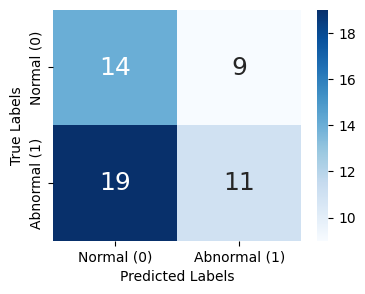

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import json
import re
import numpy as np
root_dir = 'MIMIC-CXR-filtered/test'
case_names = os.listdir(root_dir)
pred_json = 'Results/263_fewshot_gpt-4-turbo.json'
label_json = 'labels.json'

with open(pred_json, 'r') as f:
    preds = json.load(f)
with open(label_json, 'r') as f:
    labels = json.load(f)

question = "Does the report mention any abnormalities, unhealthy findings, or potential health concerns? Respond with one number: 1 for 'yes' (if the report identifies any abnormality or issue) or 0 for 'no' (if the report states the findings are normal and healthy)."

label_list = []
pred_list = []

for case_name in tqdm(case_names):
    findings = preds[case_name].split(':')[-1]
    context = 'Here is the finding section of one X-ray report: ' + re.sub(r"\s+", " ", findings).strip()
    prompt = f"{context}\n\nQuestion: {question}\n\nAnswer:"

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
        inputs["input_ids"],
        max_new_tokens=10,
        temperature=0.0,
        top_p=1.0,
        do_sample=False
    )

    pred = tokenizer.decode(output[0], skip_special_tokens=True).split("Answer:")[-1].strip()
    label = labels[case_name]
    label_list.append(int(label.split('\n')[0]))
    pred_list.append(int(pred.split('\n')[0]))

accuracy = accuracy_score(label_list, pred_list)
precision = precision_score(label_list, pred_list)
recall = recall_score(label_list, pred_list)
f1 = f1_score(label_list, pred_list)
conf_matrix = confusion_matrix(label_list, pred_list)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Abnormal (1)'], yticklabels=['Normal (0)', 'Abnormal (1)'], annot_kws={"size": 18})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
conf_matrix_file = './cm_4turbo_few.png'
plt.savefig(conf_matrix_file, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved as {conf_matrix_file}")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")